In [1]:
# 导入必要的库

import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('dark')

import os

import warnings
warnings.filterwarnings('ignore')
os.chdir('ruc_程序设计大作业/code/data')

## 数据集构建

### 构建预测目标

In [2]:
# 读取曲面特征
atm_vol = pd.read_csv('./surface_features/atm_vol.csv')
skewness = pd.read_csv('./surface_features/skewness.csv')
term_structure = pd.read_csv('./surface_features/term_structure.csv')

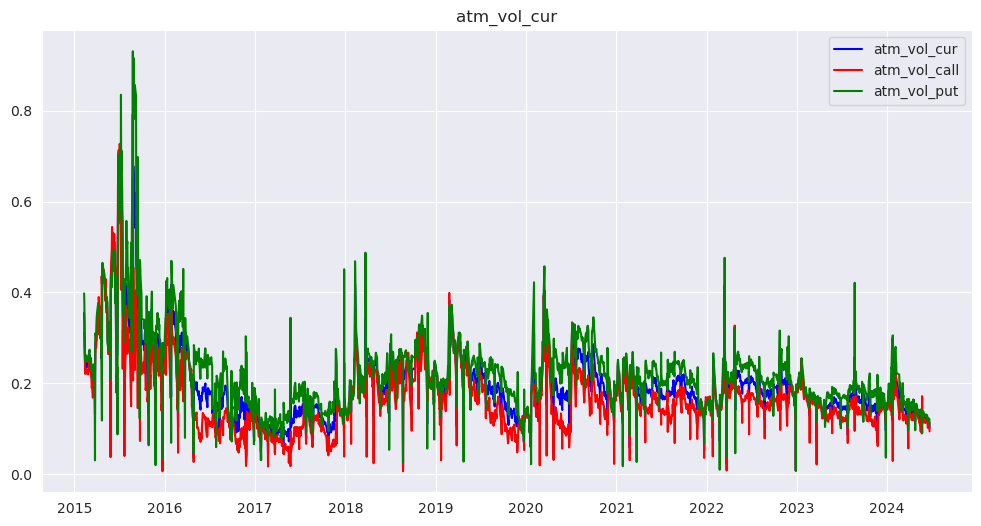

In [3]:
# 曲面平移特征-近月平值隐含波动率
call_cur_atm = atm_vol[(atm_vol.expiration_order == 0)&(atm_vol.option_type == '购')].reset_index(drop=True).groupby(['datetime']).impliedVol.mean().reset_index()
put_cur_atm = atm_vol[(atm_vol.expiration_order == 0)&(atm_vol.option_type == '沽')].reset_index(drop=True).groupby(['datetime']).impliedVol.mean().reset_index()

assert len(call_cur_atm) == len(put_cur_atm)
atm_vol_cur = pd.merge(call_cur_atm, put_cur_atm, on='datetime', suffixes=('_call', '_put'))
atm_vol_cur['impliedVol'] = (atm_vol_cur['impliedVol_call'] + atm_vol_cur['impliedVol_put']) / 2

plt.figure(figsize=(12,6))
plt.plot(pd.to_datetime(atm_vol_cur['datetime']), atm_vol_cur['impliedVol'], label='atm_vol_cur', color='blue')
plt.plot(pd.to_datetime(atm_vol_cur['datetime']), atm_vol_cur['impliedVol_call'], label='atm_vol_call', color='red')
plt.plot(pd.to_datetime(atm_vol_cur['datetime']), atm_vol_cur['impliedVol_put'], label='atm_vol_put', color='green')
plt.title('atm_vol_cur')
plt.grid()
plt.legend()
plt.show()

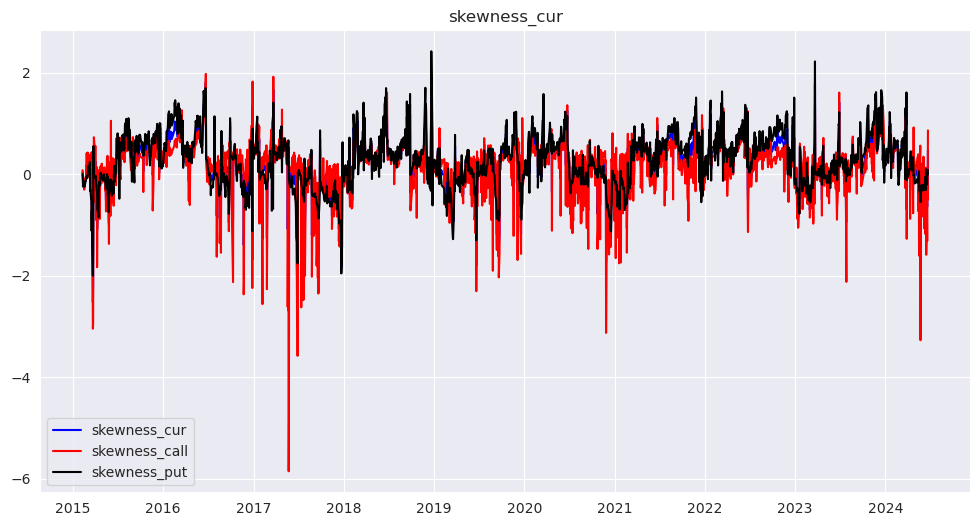

In [4]:
call_cur_skewness = skewness[(skewness.expiration_order == 0)&(skewness.option_type == '购')].reset_index(drop=True).groupby(['datetime']).skewness.mean().reset_index()
put_cur_skewness = skewness[(skewness.expiration_order == 0)&(skewness.option_type == '沽')].reset_index(drop=True).groupby(['datetime']).skewness.mean().reset_index()

assert len(call_cur_skewness) == len(put_cur_skewness)
skewness_cur = pd.merge(call_cur_skewness, put_cur_skewness, on='datetime', suffixes=('_call', '_put'))
skewness_cur['skewness'] = (skewness_cur['skewness_call'] + skewness_cur['skewness_put']) / 2

plt.figure(figsize=(12,6))
plt.plot(pd.to_datetime(skewness_cur['datetime']), skewness_cur['skewness'], label='skewness_cur', color='blue')
plt.plot(pd.to_datetime(skewness_cur['datetime']), skewness_cur['skewness_call'], label='skewness_call', color='red')
plt.plot(pd.to_datetime(skewness_cur['datetime']), skewness_cur['skewness_put'], label='skewness_put', color='black')
plt.title('skewness_cur')
plt.grid()
plt.legend()
plt.show()

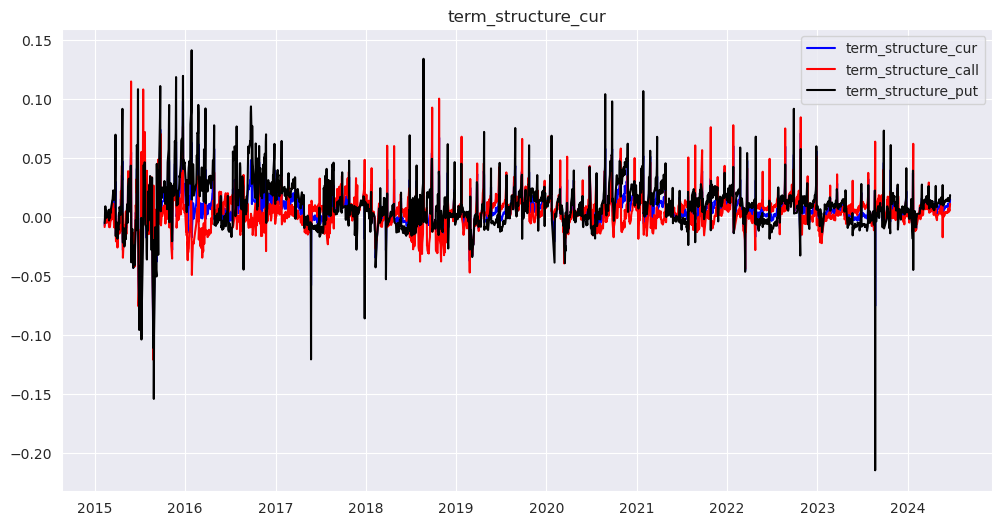

In [5]:
call_term_structure = term_structure[(term_structure.option_type == '购')].reset_index(drop=True).groupby(['datetime']).atm_term_structure.mean().reset_index()
put_term_structure = term_structure[(term_structure.option_type == '沽')].reset_index(drop=True).groupby(['datetime']).atm_term_structure.mean().reset_index()

assert len(call_term_structure) == len(put_term_structure)
term_structure_cur = pd.merge(call_term_structure, put_term_structure, on='datetime', suffixes=('_call', '_put'))
term_structure_cur['atm_term_structure'] = (term_structure_cur['atm_term_structure_call'] + term_structure_cur['atm_term_structure_put']) / 2

plt.figure(figsize=(12,6))
plt.plot(pd.to_datetime(term_structure_cur['datetime']), term_structure_cur['atm_term_structure'], label='term_structure_cur', color='blue')
plt.plot(pd.to_datetime(term_structure_cur['datetime']), term_structure_cur['atm_term_structure_call'], label='term_structure_call', color='red')
plt.plot(pd.to_datetime(term_structure_cur['datetime']), term_structure_cur['atm_term_structure_put'], label='term_structure_put', color='black')
plt.title('term_structure_cur')
plt.grid()
plt.legend()
plt.show()

In [6]:
labels = pd.merge(atm_vol_cur, skewness_cur, on='datetime', how='outer')
labels = pd.merge(labels, term_structure_cur, on='datetime', how='outer')
labels = labels[['datetime', 'impliedVol', 'skewness', 'atm_term_structure']]
labels['datetime'] = pd.to_datetime(labels['datetime'])
labels.corr()

,impliedVol,skewness,atm_term_structure
impliedVol,1.000000,0.071606,-0.532509
skewness,0.071606,1.000000,0.013162
atm_term_structure,-0.532509,0.013162,1.000000


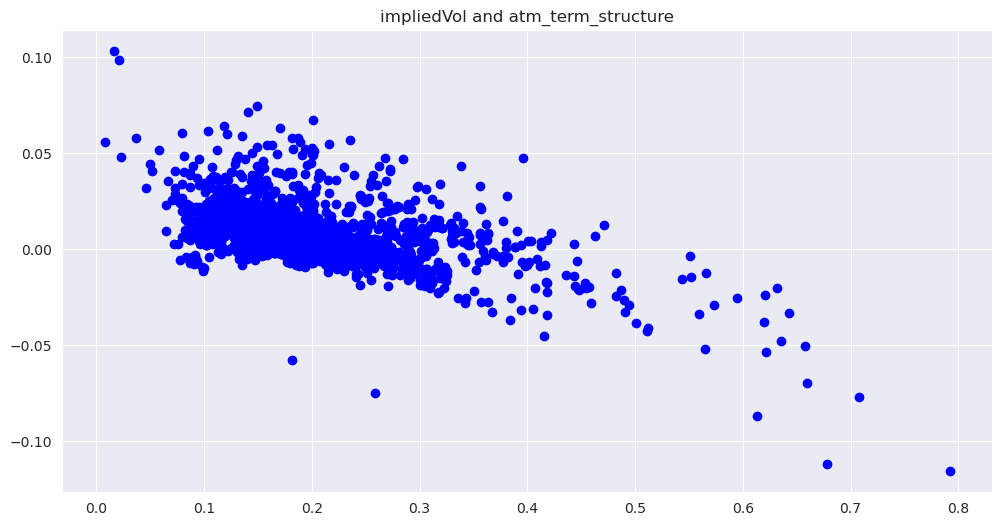


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=160.6572, p=0.0000  , df_denom=2272, df_num=1
ssr based chi2 test:   chi2=160.8693, p=0.0000  , df=1
likelihood ratio test: chi2=155.4363, p=0.0000  , df=1
parameter F test:         F=160.6572, p=0.0000  , df_denom=2272, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7159  , p=0.1904  , df_denom=2272, df_num=1
ssr based chi2 test:   chi2=1.7181  , p=0.1899  , df=1
likelihood ratio test: chi2=1.7175  , p=0.1900  , df=1
parameter F test:         F=1.7159  , p=0.1904  , df_denom=2272, df_num=1


{1: ({'ssr_ftest': (1.7158572744880793, 0.190359605960762, 2272.0, 1),
   'ssr_chi2test': (1.7181229311005195, 0.18993484433602859, 1),
   'lrtest': (1.7174744781295885, 0.19001845990927996, 1),
   'params_ftest': (1.7158572744881502, 0.1903596059606469, 2272.0, 1.0)},
   array([[0., 1., 0.]])])}

In [7]:
# impliedVol和atm_term_structure的关联性
plt.figure(figsize=(12,6))
plt.scatter(labels['impliedVol'], labels['atm_term_structure'], color='blue')
plt.title('impliedVol and atm_term_structure')
plt.grid()
plt.show()
# 格兰杰因果检验
grangercausalitytests(labels[['impliedVol', 'atm_term_structure']], 1)
# 反向
grangercausalitytests(labels[['atm_term_structure', 'impliedVol']], 1)

### 合并因子

In [8]:
option_factors = pd.read_csv('./factors/option_factors.csv')
general = pd.read_csv('./factors/general_factors.csv')
und_data = pd.read_csv('./factors/und_factors.csv')

In [9]:
label_cols = ['impliedVol', 'skewness', 'atm_term_structure']
id_col = ['datetime']
option_factors['datetime'] = pd.to_datetime(option_factors['datetime'])
general['datetime'] = pd.to_datetime(general['datetime'])
und_data['datetime'] = pd.to_datetime(und_data['datetime'])
# 时间特征
def time_feature(df):
    df['year'] = df['datetime'].dt.year
    df['month'] = df['datetime'].dt.month
    df['day'] = df['datetime'].dt.day
    df['dayofweek'] = df['datetime'].dt.dayofweek
    return df
# 合并
dataset = pd.merge(time_feature(general), option_factors, on='datetime', how='inner')
dataset = pd.merge(dataset, und_data, on='datetime', how='inner')
dataset = pd.merge(dataset, labels, on='datetime', how='inner')
dataset.head()

,datetime,r_1Y,r_3m,r_10Y,ndq,diff_r,year,month,day,dayofweek,...,cjbs,log_return,return,hv_1,hv_5,hv_22,hv_66,impliedVol,skewness,atm_term_structure
0,2015-02-09,3.0856,3.1228,3.4236,4726.01,0.3380,2015,2,9,0,...,0,0.017309,0.017460,0.000300,0.000305,0.000886,0.000785,0.355165,0.042121,-0.006599
1,2015-02-10,3.0932,3.1516,3.4299,4787.65,0.3367,2015,2,10,1,...,0,0.016171,0.016302,0.000261,0.000187,0.000898,0.000789,0.338991,0.007435,-0.004143
2,2015-02-11,3.0928,3.1516,3.3955,4801.18,0.3027,2015,2,11,2,...,0,0.004633,0.004643,0.000021,0.000152,0.000894,0.000789,0.289229,-0.137441,0.000569
3,2015-02-12,3.0872,3.1388,3.3865,4857.61,0.2993,2015,2,12,3,...,0,0.001679,0.001681,0.000003,0.000141,0.000893,0.000777,0.270184,-0.089587,0.004438
4,2015-02-13,3.0859,3.1088,3.3552,4893.84,0.2693,2015,2,13,4,...,0,0.002514,0.002517,0.000006,0.000118,0.000893,0.000775,0.235578,-0.135373,0.003718


In [10]:
dropCols = ['PCR_far', 'PCR_season']
dataset.drop(dropCols, axis=1, inplace=True)
dataset.fillna(method='ffill', inplace=True) # 知识点：fillna(method='ffill')用前一个值填充，在时序预测中常用，这样有效避免了未来数据的问题
dataset.isnull().sum() # 知识点：isnull().sum()查看缺失值

datetime              0
r_1Y                  0
r_3m                  0
r_10Y                 0
ndq                   0
diff_r                0
year                  0
month                 0
day                   0
dayofweek             0
vix                   0
PCR_cur               0
PCR_next              0
close                 0
open                  0
high                  0
low                   0
preclose              0
volume                0
amount                0
cjbs                  0
log_return            0
return                0
hv_1                  0
hv_5                  0
hv_22                 0
hv_66                 0
impliedVol            0
skewness              0
atm_term_structure    0
dtype: int64

In [11]:
id_cols = ['datetime']
time_cols = ['year', 'month', 'day', 'dayofweek']
general_cols = ['r_1Y', 'r_3m', 'r_10Y', 'ndq', 'diff_r']
option_cols = ['vix', 'PCR_cur', 'PCR_next']
und_cols = [ 'close', 'open', 'high', 'low', 'preclose', 'volume', 'amount', 'cjbs', 'log_return', 'return', 'hv_1', 'hv_5', 'hv_22', 'hv_66']
label_cols = ['impliedVol', 'skewness', 'atm_term_structure']

pre_und_cols = und_cols
und_cols = [i + '_und' for i in und_cols] # 知识点：列表推导式，提高代码的简洁性
dataset.rename(columns=dict(zip(pre_und_cols, und_cols)), inplace=True)
dataset.to_csv('./factors/dataset.csv', index=False)
dataset.head()

,datetime,r_1Y,r_3m,r_10Y,ndq,diff_r,year,month,day,dayofweek,...,cjbs_und,log_return_und,return_und,hv_1_und,hv_5_und,hv_22_und,hv_66_und,impliedVol,skewness,atm_term_structure
0,2015-02-09,3.0856,3.1228,3.4236,4726.01,0.3380,2015,2,9,0,...,0,0.017309,0.017460,0.000300,0.000305,0.000886,0.000785,0.355165,0.042121,-0.006599
1,2015-02-10,3.0932,3.1516,3.4299,4787.65,0.3367,2015,2,10,1,...,0,0.016171,0.016302,0.000261,0.000187,0.000898,0.000789,0.338991,0.007435,-0.004143
2,2015-02-11,3.0928,3.1516,3.3955,4801.18,0.3027,2015,2,11,2,...,0,0.004633,0.004643,0.000021,0.000152,0.000894,0.000789,0.289229,-0.137441,0.000569
3,2015-02-12,3.0872,3.1388,3.3865,4857.61,0.2993,2015,2,12,3,...,0,0.001679,0.001681,0.000003,0.000141,0.000893,0.000777,0.270184,-0.089587,0.004438
4,2015-02-13,3.0859,3.1088,3.3552,4893.84,0.2693,2015,2,13,4,...,0,0.002514,0.002517,0.000006,0.000118,0.000893,0.000775,0.235578,-0.135373,0.003718


## 因子评估

In [12]:
x_cols = general_cols + option_cols + und_cols
x = dataset[x_cols]

### 特征之间

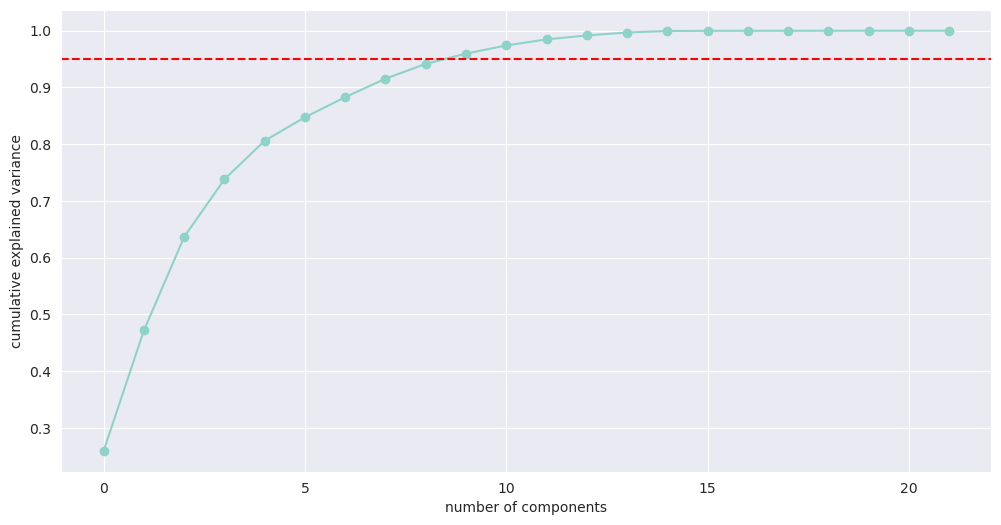

In [13]:
# 逐列标准化
for col in x.columns:
    x[col] = (x[col] - x[col].mean()) / x[col].std()

# pca
pca = PCA() # 知识点：PCA()，主成分分析
pca.fit(x)
plt.figure(figsize=(12,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.axline((0, 0.95), (1, 0.95), color='red', linestyle='--')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.grid()
plt.show()

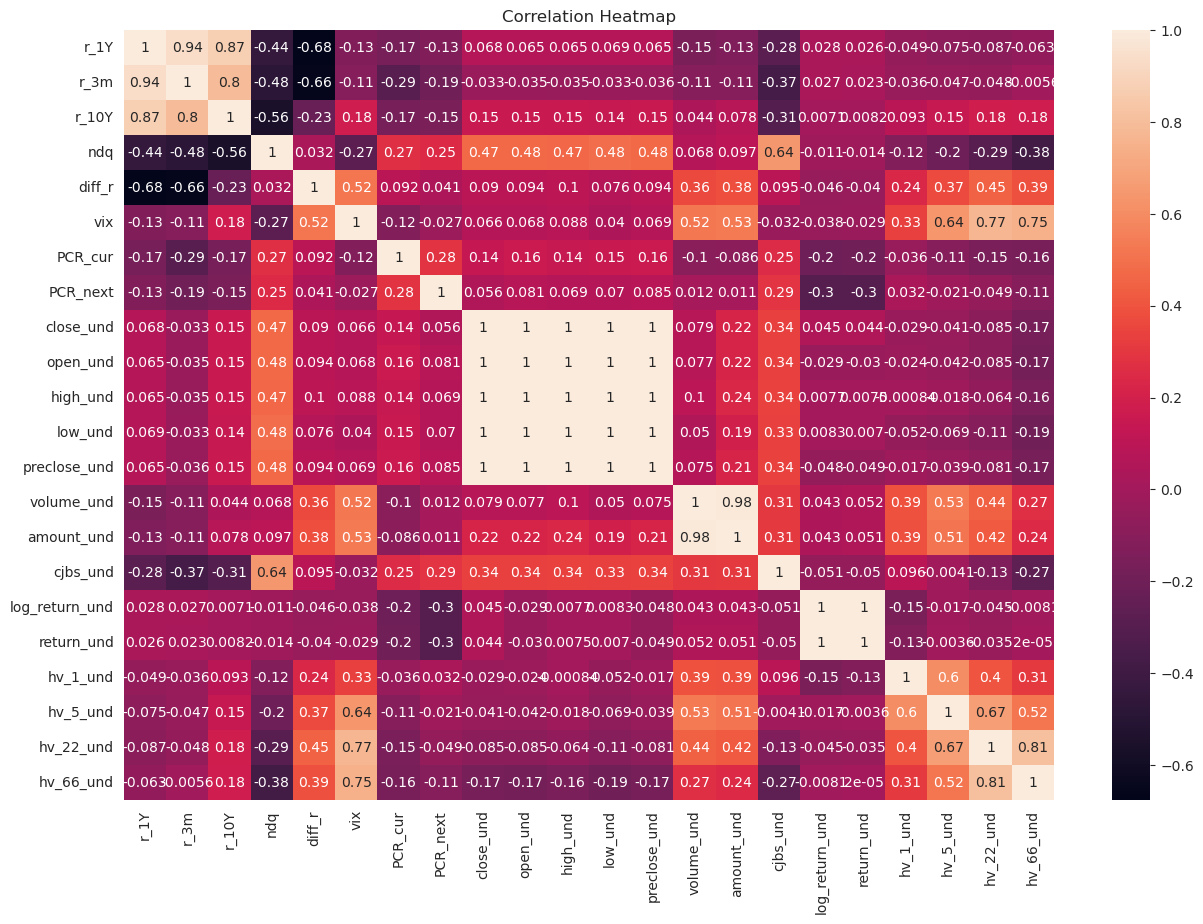

In [14]:
# 相关性热力图
plt.figure(figsize=(15,10))
sns.heatmap(dataset[x_cols].corr(), annot=True)
plt.title('Correlation Heatmap')
plt.show()

### 特征和预测目标之间

In [16]:
# 计算ic：t期因子与t+1期标签的相关性
def calculate_ic(df, label_cols, x_cols):
    ic = []
    for label in label_cols:
        for col in x_cols:
            print(f'Calculating IC for {col} and {label}')
            print(df[col])
            ic.append(df[col].shift(-1).corr(df[label])) # 知识点：append()，将元素添加到列表末尾
    ic = np.array(ic).reshape(len(label_cols), len(x_cols)) # 知识点：reshape()，将数组转换为指定的形状
    ic = pd.DataFrame(ic, index=label_cols, columns=x_cols)
    return ic

ic = calculate_ic(dataset, label_cols, x_cols)

Calculating IC for r_1Y and impliedVol
0       3.0856
1       3.0932
2       3.0928
3       3.0872
4       3.0859
         ...  
2271    1.6040
2272    1.6040
2273    1.5990
2274    1.5990
2275    1.5915
Name: r_1Y, Length: 2276, dtype: float64
Calculating IC for r_3m and impliedVol
0       3.1228
1       3.1516
2       3.1516
3       3.1388
4       3.1088
         ...  
2271    1.5376
2272    1.5204
2273    1.5227
2274    1.5068
2275    1.5007
Name: r_3m, Length: 2276, dtype: float64
Calculating IC for r_10Y and impliedVol
0       3.4236
1       3.4299
2       3.3955
3       3.3865
4       3.3552
         ...  
2271    2.2609
2272    2.2537
2273    2.2429
2274    2.2445
2275    2.2571
Name: r_10Y, Length: 2276, dtype: float64
Calculating IC for ndq and impliedVol
0        4726.01
1        4787.65
2        4801.18
3        4857.61
4        4893.84
          ...   
2271    17857.02
2272    17862.23
2273    17862.23
2274    17721.59
2275    17689.36
Name: ndq, Length: 2276, dtype: float6

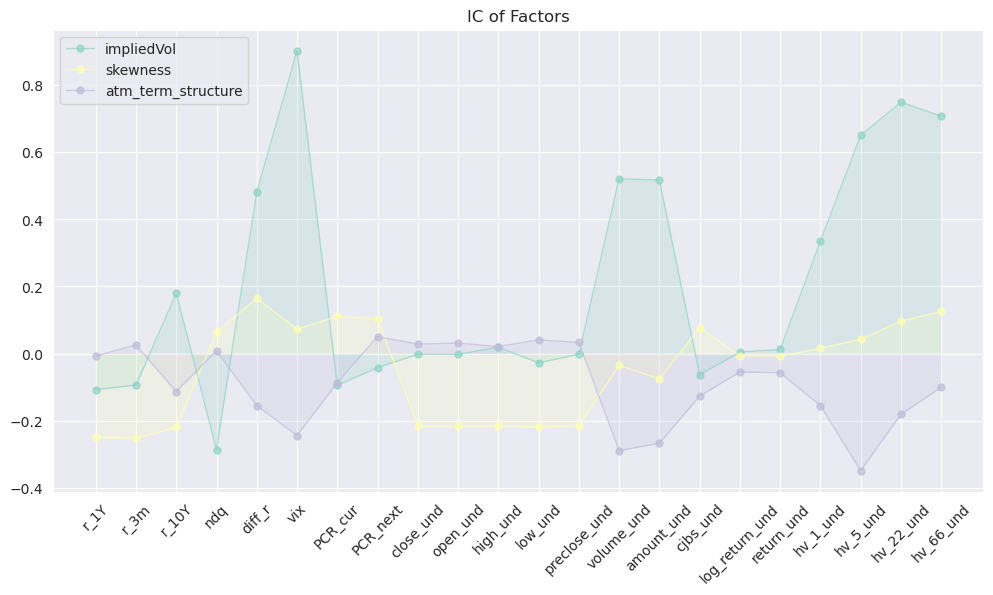

In [17]:
# ic折线图
plt.figure(figsize=(12, 6))
for i in range(len(ic)):
    plt.plot(ic.columns, ic.iloc[i], marker='o', alpha=0.7, linestyle='-', markersize=5, linewidth=1, label=ic.index[i])
    plt.fill_between(ic.columns, ic.iloc[i], alpha=0.2)  # 知识点：fill_between()函数用于填充两个函数之间的区域，使得图形看起来更加美观
plt.legend()
plt.title('IC of Factors')
plt.grid()
plt.xticks(rotation=45)
plt.show()

### 标签自身

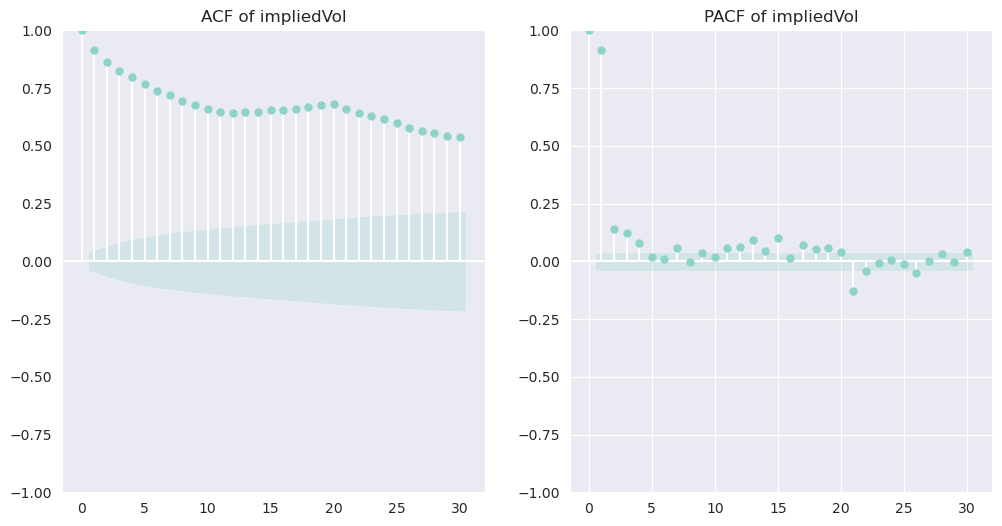

In [18]:
# acf和pacf
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
plot_acf(dataset['impliedVol'], lags=30, ax=axes[0], title='ACF of impliedVol')
plot_pacf(dataset['impliedVol'], lags=30, ax=axes[1], title='PACF of impliedVol')
plt.grid()
plt.show()

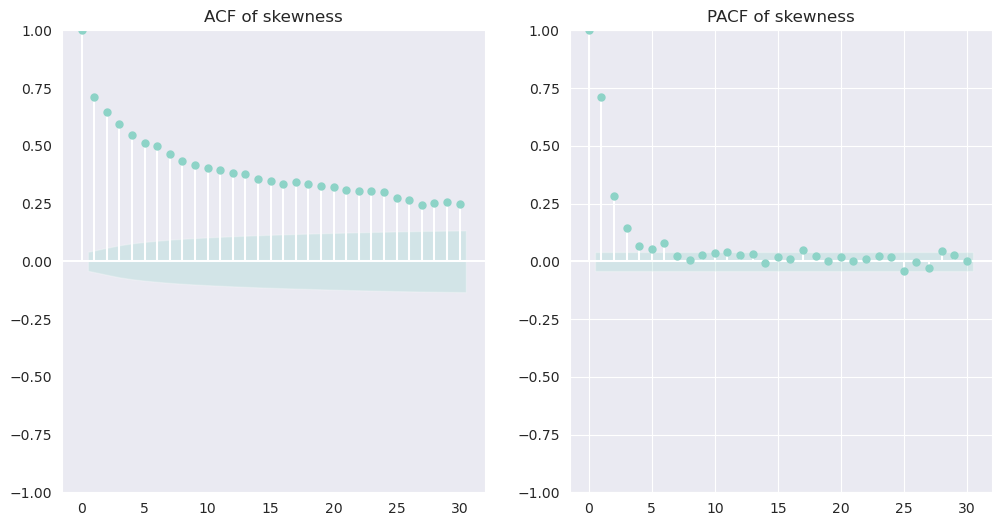

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
plot_acf(dataset['skewness'], lags=30, ax=axes[0], title='ACF of skewness')
plot_pacf(dataset['skewness'], lags=30, ax=axes[1], title='PACF of skewness')
plt.grid()
plt.show()

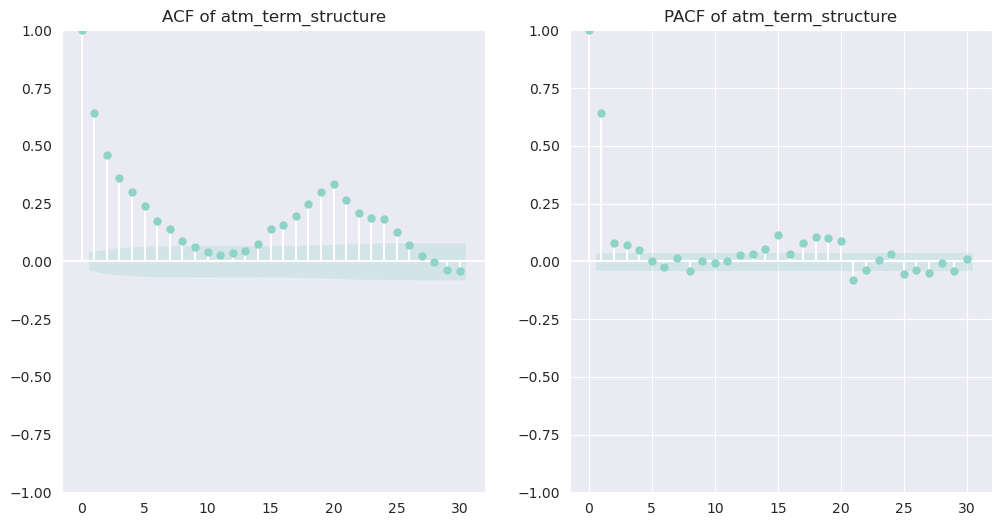

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
plot_acf(dataset['atm_term_structure'], lags=30, ax=axes[0], title='ACF of atm_term_structure')
plot_pacf(dataset['atm_term_structure'], lags=30, ax=axes[1], title='PACF of atm_term_structure')
plt.grid()
plt.show()